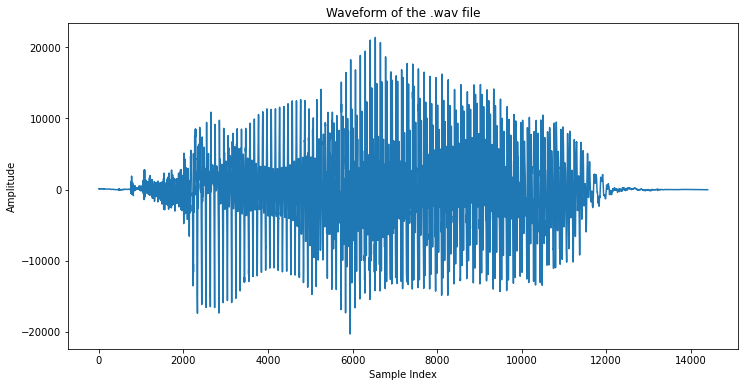

Sample Rate: 24000
Tensor Shape: torch.Size([14400])
Tensor Data Type: torch.int16


In [193]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
## averages stereo to make mono
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

# Load the .wav file
sample_rate, data = wavfile.read('hello.wav')

# Convert the numpy array to a torch tensor
tensor_data = torch.from_numpy(data)

# Plot the waveform
plt.figure(figsize=(12, 6))
plt.plot(data)
plt.title('Waveform of the .wav file')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()

# Print some information about the tensor
print(f'Sample Rate: {sample_rate}')
print(f'Tensor Shape: {tensor_data.shape}')
print(f'Tensor Data Type: {tensor_data.dtype}')


In [194]:

from torch.utils.data import Dataset, DataLoader
class WaveformDataset(Dataset):
    def __init__(self, wav_data):
        self.wav_data = wav_data
        self.time_steps = np.arange(wav_data.shape[0])
        self.length = len(wav_data)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return self.wav_data[idx], self.time_steps[idx]

class RandomBatchSampler(torch.utils.data.Sampler):
    def __init__(self, data_source, batch_size):
        self.data_source = data_source
        self.batch_size = batch_size

    def __iter__(self):
        indices = torch.randperm(len(self.data_source)).tolist()
        for i in range(0, len(indices), self.batch_size):
            yield indices[i:i + self.batch_size]

    def __len__(self):
        return len(self.data_source) // self.batch_size

In [195]:
class PhaseAgreementLoss(nn.Module):
    def __init__(self):
        super(PhaseAgreementLoss, self).__init__()
    
    def forward(self, input, target):
        product = input * target
        loss = torch.sum(1- torch.sigmoid(product + 3))
        return loss

In [217]:
class SineWaveLayerMult_2(nn.Module):
    def __init__(self, n, sample_rate, frequencies=None):
        super(SineWaveLayerMult_2, self).__init__()
        self.n = n
        self.sample_rate = sample_rate

        if frequencies is None:
            # Create default frequency tensor based on sample_rate
            #self.frequencies = torch.tensor([sample_rate / (2 ** i) for i in range(n)], dtype=torch.float32)
            self.frequencies = torch.tensor([ (sample_rate/2/n)*(i+1) for i in range(n)], dtype=torch.float32)
            
        else:
            assert len(frequencies) == n, "Frequencies list must be of length n"
            self.frequencies = torch.tensor(frequencies, dtype=torch.float32)
        
        # Create wavelength tensor
        self.wavelengths = torch.tensor([2 ** i for i in range(n)], dtype=torch.float32)
        
        # Initialize Amplitude with normal distribution
        self.amplitudes = nn.Parameter(torch.randn(n))
        self.amplitudes_2 = nn.Parameter(torch.randn(n))
        
        # Initialize Phi with normal distribution between 0 and corresponding wavelength
        self.phi = nn.Parameter(torch.abs(torch.randn(n)) % self.wavelengths)
        self.phi_2 = nn.Parameter(torch.abs(torch.randn(n)) % self.wavelengths)

    def forward(self, t):
        # Expand frequencies and phi to match the shape of t
        frequencies = self.frequencies.unsqueeze(1)  # Shape: (n, 1)
        phi = self.phi.unsqueeze(1)  # Shape: (n, 1)
        phi_2 = self.phi_2.unsqueeze(1)
        amplitudes = self.amplitudes.unsqueeze(1)  # Shape: (n, 1)
        amplitudes_2 = self.amplitudes_2.unsqueeze(1)
    
        # Compute the sine waves and sum them
        waves = amplitudes * torch.sin(2 * torch.pi * frequencies * (t + phi) / self.sample_rate)  # Shape: (n, time_steps)
        waves_2 = amplitudes_2 * torch.sin(2 * torch.pi * (frequencies+self.sample_rate/(4*n)) * (t + phi_2) / self.sample_rate)
        batch = waves.shape[-1]
        outer_product = waves.unsqueeze(1) * waves_2.unsqueeze(0)
        flattened_tensor = outer_product.view(self.n * self.n,batch)
        

        
        y = flattened_tensor.sum(dim=0)  # Sum over all waves, shape: (time_steps,)

        return y

In [197]:
[ (sample_rate/2/n)*(i+1) for i in range(n)]

[600.0,
 1200.0,
 1800.0,
 2400.0,
 3000.0,
 3600.0,
 4200.0,
 4800.0,
 5400.0,
 6000.0,
 6600.0,
 7200.0,
 7800.0,
 8400.0,
 9000.0,
 9600.0,
 10200.0,
 10800.0,
 11400.0,
 12000.0]

In [219]:
sample_rate/(4*n)

200.0

In [231]:
n = 50 # Set above
print(sample_rate)

network = SineWaveLayerMult_2(n, sample_rate)
print(network.frequencies)
network.train()

24000
tensor([  240.,   480.,   720.,   960.,  1200.,  1440.,  1680.,  1920.,  2160.,
         2400.,  2640.,  2880.,  3120.,  3360.,  3600.,  3840.,  4080.,  4320.,
         4560.,  4800.,  5040.,  5280.,  5520.,  5760.,  6000.,  6240.,  6480.,
         6720.,  6960.,  7200.,  7440.,  7680.,  7920.,  8160.,  8400.,  8640.,
         8880.,  9120.,  9360.,  9600.,  9840., 10080., 10320., 10560., 10800.,
        11040., 11280., 11520., 11760., 12000.])


SineWaveLayerMult_2()

In [232]:
# Define a loss function and optimizer
hyperparameters = {'learning_rate': 0.0001
                   , 'epochs': 1000
                   ,'batch_size': 100}

# Create the dataloader with the custom random batch sampler
dataset = WaveformDataset(data)
batch_size = 1000
sampler = RandomBatchSampler(dataset, batch_size)
dataloader = DataLoader(dataset, batch_sampler=sampler)

In [235]:
#this trains them seperately. 



#criterion = nn.MSELoss()
#criterion = PhaseAgreementLoss()
#optimizer = optim.Adam([network.amplitudes, network.phi], lr=hyperparameters['learning_rate'])

#for layer
### for the mult_2
optimizer_amplitudes = optim.Adam([network.amplitudes,network.amplitudes_2], lr=0.001) #is mle correct?
optimizer_phi = optim.Adam([network.phi,network.phi_2], lr=0.001) 

#optimizer_amplitudes = optim.Adam([network.amplitudes], lr=0.0001) #is mle correct?
#optimizer_phi = optim.Adam([network.phi], lr=0.0001)  

#for network
#optimizer_amplitudes = optim.Adam(network.get_amplitude_parameters(), lr=0.001)
#optimizer_phi = optim.Adam(network.get_phi_parameters(), lr=0.001)  
    # Define loss functions
criterion_mse = nn.MSELoss() #AmplitudeAgreementLoss() 
criterion_phase_agree = PhaseAgreementLoss()


# Create objects to hold gradients
amplitude_grads = []
phi_grads = []


# Training loop
for epoch in range(hyperparameters['epochs']):
    running_loss_mse = 0.0
    running_loss_pa = 0.0
    
    for i, (batch_wav, batch_time) in enumerate(dataloader):
    
    
        # Zero the parameter gradients

        optimizer_amplitudes.zero_grad()
        optimizer_phi.zero_grad()
        
        
        # Forward pass
        output = network(batch_time)


        loss_mse = criterion_mse(output, batch_wav.float())
        loss_phase_agree = criterion_phase_agree(output, batch_wav)
        
        loss_mse.backward(retain_graph=True) 
        loss_phase_agree.backward()
        
        optimizer_phi.step()
        optimizer_amplitudes.step()

        
        running_loss_mse += loss_mse.item()
        running_loss_pa += loss_phase_agree.item()
    
    
    if (epoch%100==0):
        print(f"Epoch {epoch} - Running Loss MSE: {running_loss_mse} - Phase Agreement: {loss_phase_agree}")


print('Finished Training')

Epoch 0 - Running Loss MSE: 373812040.0 - Phase Agreement: 190.189697265625
Epoch 100 - Running Loss MSE: 374001628.0 - Phase Agreement: 176.16273498535156
Epoch 200 - Running Loss MSE: 375255090.0 - Phase Agreement: 181.0949249267578
Epoch 300 - Running Loss MSE: 374992134.0 - Phase Agreement: 201.61846923828125
Epoch 400 - Running Loss MSE: 375130256.0 - Phase Agreement: 177.0948486328125
Epoch 500 - Running Loss MSE: 374731832.0 - Phase Agreement: 186.13870239257812
Epoch 600 - Running Loss MSE: 372912200.0 - Phase Agreement: 175.14227294921875
Epoch 700 - Running Loss MSE: 375396186.0 - Phase Agreement: 210.14117431640625
Epoch 800 - Running Loss MSE: 373838612.0 - Phase Agreement: 188.189697265625
Epoch 900 - Running Loss MSE: 372761830.0 - Phase Agreement: 202.0948486328125
Finished Training


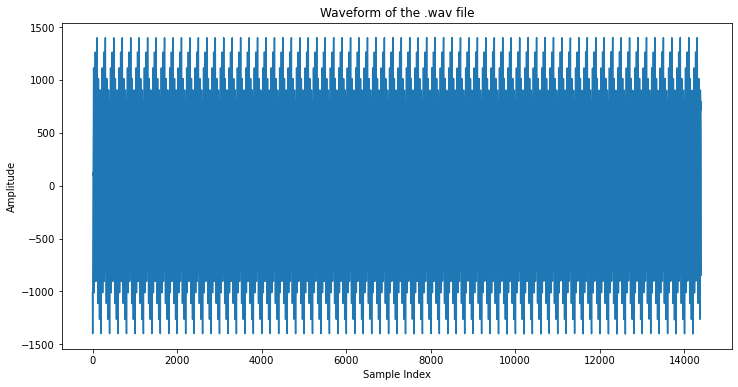

In [236]:
t = np.arange(data.shape[0])
network.eval()

def run_inference_in_batches(network, input_list, batch_size=100):
    # Convert the input list to a PyTorch tensor
    input_tensor = torch.tensor(input_list, dtype=torch.float32)
    
    # List to collect the outputs
    outputs = []
    
    # Process the input tensor in batches
    for start in range(0, len(input_tensor), batch_size):
        end = min(start + batch_size, len(input_tensor))
        batch = input_tensor[start:end]
        
        # Pass the batch through the network
        with torch.no_grad():  # No need to compute gradients during inference
            batch_output = network(batch)
        
        # Append the batch output to the outputs list
        outputs.append(batch_output)
    
    # Concatenate all batch outputs into a single tensor
    final_output = torch.cat(outputs, dim=0)
    
    return final_output

o = run_inference_in_batches(network, t)

plt.figure(figsize=(12, 6))
plt.plot(o)
plt.title('Waveform of the .wav file')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()

In [237]:
from scipy.io.wavfile import write

def save_to_wave(output_list, sample_rate, filename):
    # Convert the output list to a numpy array
    output_array = np.array(output_list, dtype=np.float32)
    
    # Normalize the output to the range [-1, 1] if necessary
    max_val = np.max(np.abs(output_array))
    if max_val > 0:
        output_array = output_array / max_val
    
    # Convert to 16-bit PCM format
    output_array = (output_array * 32767).astype(np.int16)
    
    # Save the array to a wave file
    write(filename, sample_rate, output_array)

    
output_list = o.tolist()
filename = 'output_wave.wav'

# Save the output list to a wave file
save_to_wave(output_list, sample_rate, filename)






In [210]:
#this trains THE LOSS FUNCTIONS ADDED TOGETHER, ONE BACKWARD STEP.


#criterion = nn.MSELoss()
#criterion = PhaseAgreementLoss()
#optimizer = optim.Adam([network.amplitudes, network.phi], lr=hyperparameters['learning_rate'])

#for layer
optimizer = optim.Adam([network.amplitudes,network.phi], lr=0.0001) #is mle correct?
#optimizer_phi = optim.Adam([network.phi], lr=0.0001)  
#for network
#optimizer_amplitudes = optim.Adam(network.get_amplitude_parameters(), lr=0.001)
#optimizer_phi = optim.Adam(network.get_phi_parameters(), lr=0.001)  
    # Define loss functions
criterion_mse = nn.MSELoss() #AmplitudeAgreementLoss() 
criterion_phase_agree = PhaseAgreementLoss()



# Training loop
for epoch in range(hyperparameters['epochs']):
    running_loss_mse = 0.0
    running_loss_pa = 0.0
    
    for i, (batch_wav, batch_time) in enumerate(dataloader):
    
    
        # Zero the parameter gradients
        #optimizer.zero_grad()
        optimizer.zero_grad()
      
        
        
        # Forward pass
        output = network(batch_time)

        # Calculate loss
        #loss = criterion(output, batch_wav)
        loss_mse = criterion_mse(output, batch_wav.float())
        loss_phase_agree = criterion_phase_agree(output, batch_wav)
        
        loss = loss_mse + loss_phase_agree
        loss.backward()
        optimizer.step()


        
        running_loss_mse += loss_mse.item()/batch_time.shape[0]
        running_loss_pa += loss_phase_agree.item()/batch_time.shape[0]
    
    
    if (epoch%10==0):
        print(f"Epoch {epoch} - Running Loss MSE: {running_loss_mse} - Phase Agreement: {loss_phase_agree}")


print('Finished Training')

Epoch 0 - Running Loss MSE: 572332.245 - Phase Agreement: 392.28759765625
Epoch 10 - Running Loss MSE: 572332.1350000001 - Phase Agreement: 384.86370849609375
Epoch 20 - Running Loss MSE: 572332.1450000001 - Phase Agreement: 408.79791259765625
Epoch 30 - Running Loss MSE: 572332.095 - Phase Agreement: 425.1658935546875
Epoch 40 - Running Loss MSE: 572332.1124999999 - Phase Agreement: 396.64849853515625
Epoch 50 - Running Loss MSE: 572332.1925 - Phase Agreement: 417.7422790527344
Epoch 60 - Running Loss MSE: 572332.1025000002 - Phase Agreement: 401.3305969238281
Epoch 70 - Running Loss MSE: 572332.15 - Phase Agreement: 395.1729431152344
Epoch 80 - Running Loss MSE: 572332.23 - Phase Agreement: 395.796875
Epoch 90 - Running Loss MSE: 572332.2725000001 - Phase Agreement: 391.1426086425781
Epoch 100 - Running Loss MSE: 572332.1375000001 - Phase Agreement: 388.677978515625
Epoch 110 - Running Loss MSE: 572332.1525000001 - Phase Agreement: 388.3320007324219
Epoch 120 - Running Loss MSE: 5723

KeyboardInterrupt: 